<a href="https://colab.research.google.com/github/semensorokin/data_augmetation/blob/master/vectorrepresentionsUSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#augmented data

In [0]:
#choose some sentences

In [0]:
#use + faiss

In [0]:
#4 lstm model fitted on data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/UniversalEmb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/UniversalEmb


In [84]:
!ls

amazon_qa			    SQuAD.txt
google_texts.txt		    yes_no_amazon_questions_cleared.txt
multi_amazon_questions_cleared.txt


In [83]:
%cd ../ 

/content/drive/My Drive/UniversalEmb/Question_augmentation


In [0]:
!rm -rf amazon_qa/

In [87]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [90]:
embed(['cat']).shape

TensorShape([1, 512])

In [0]:
import pandas as pd
def read_trec50(file_name, typ=1):
  train = pd.read_csv(file_name, index_col=0)
  lbl2indx = {i:j for j, i in enumerate(train.labels.unique())}
  train.columns = ['text', 'labels']
  train['lbl_index'] = train.labels.apply(lambda x:lbl2indx[x])


  labels_t = [i.split(' ', 1)[0].split(':')[typ] for i in open('../TREC_10.label', encoding = 'windows-1252').readlines()]
  texts_t = [ i.split(' ', 1)[1][:-1] for i in open('../TREC_10.label', encoding = 'windows-1252').readlines()]
  test  = pd.DataFrame({'text':texts_t, 'labels': labels_t})
  test['lbl_index'] = test.labels.apply(lambda x:lbl2indx[x])

  return train, test, lbl2indx

train, test, l2i = read_trec50('../trec50_splited/trec50_5k.csv')

In [97]:
embed(train['text']).numpy().shape

(5009, 512)

In [0]:
train['vecs'] = embed(train['text']).numpy().tolist()

In [100]:
train

,text,labels,lbl_index,vecs
0,How did Jayne Mansfield die ?,manner,0,"[0.012362019158899784, 0.008489484898746014, -..."
1,How do windmills work ?,manner,0,"[0.05261087417602539, 0.026462629437446594, 0...."
2,How can SQL queries be improved ?,manner,0,"[0.015717536211013794, -0.01085334736853838, 0..."
3,How can I find out my Moon sign ?,manner,0,"[0.005114935804158449, -8.484345016768202e-06,..."
4,How do you clean an LCD monitor screen ?,manner,0,"[0.007737812586128712, 0.015500267967581749, 0..."
...,...,...,...,...
5004,What is the recommended weight of a 15 year-ol...,weight,45,"[-0.07917314767837524, -0.01400267705321312, 0..."
5005,What type of currency is used in China ?,currency,46,"[-0.07849539071321487, -0.025770487263798714, ..."
5006,What money was used here ?,currency,46,"[-0.0891684889793396, 0.020327921956777573, -0..."
5007,What money was used by them ?,currency,46,"[-0.06405258178710938, 0.007273550145328045, 0..."


In [106]:
train_vectors = train[['vecs', 'lbl_index']]
train_vectors.vecs = train_vectors.vecs.apply(np.array)
train_vectors

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,vecs,lbl_index
0,"[0.012362019158899784, 0.008489484898746014, -...",0
1,"[0.05261087417602539, 0.026462629437446594, 0....",0
2,"[0.015717536211013794, -0.01085334736853838, 0...",0
3,"[0.005114935804158449, -8.484345016768202e-06,...",0
4,"[0.007737812586128712, 0.015500267967581749, 0...",0
...,...,...
5004,"[-0.07917314767837524, -0.01400267705321312, 0...",45
5005,"[-0.07849539071321487, -0.025770487263798714, ...",46
5006,"[-0.0891684889793396, 0.020327921956777573, -0...",46
5007,"[-0.06405258178710938, 0.007273550145328045, 0...",46


In [0]:
center_of_classes = pd.DataFrame({'vecs': train_vectors.groupby('lbl_index')['vecs'].apply(np.mean).tolist(), 'lbl_index': [i for i in range(len(train.lbl_index.unique()))]})

In [113]:
from scipy.spatial.distance import cosine
distances = []
lbl2center = {i: j for i,j in zip(center_of_classes.lbl_index, center_of_classes.vecs)}
for row in train_vectors.iterrows():
  distances.append(cosine(lbl2center[row[1].lbl_index], row[1].vecs))
train_vectors['distances'] = distances
train_vectors.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,vecs,lbl_index,distances
0,"[0.012362019158899784, 0.008489484898746014, -...",0,0.586539
1,"[0.05261087417602539, 0.026462629437446594, 0....",0,0.481686
2,"[0.015717536211013794, -0.01085334736853838, 0...",0,0.611633
3,"[0.005114935804158449, -8.484345016768202e-06,...",0,0.507404
4,"[0.007737812586128712, 0.015500267967581749, 0...",0,0.576014


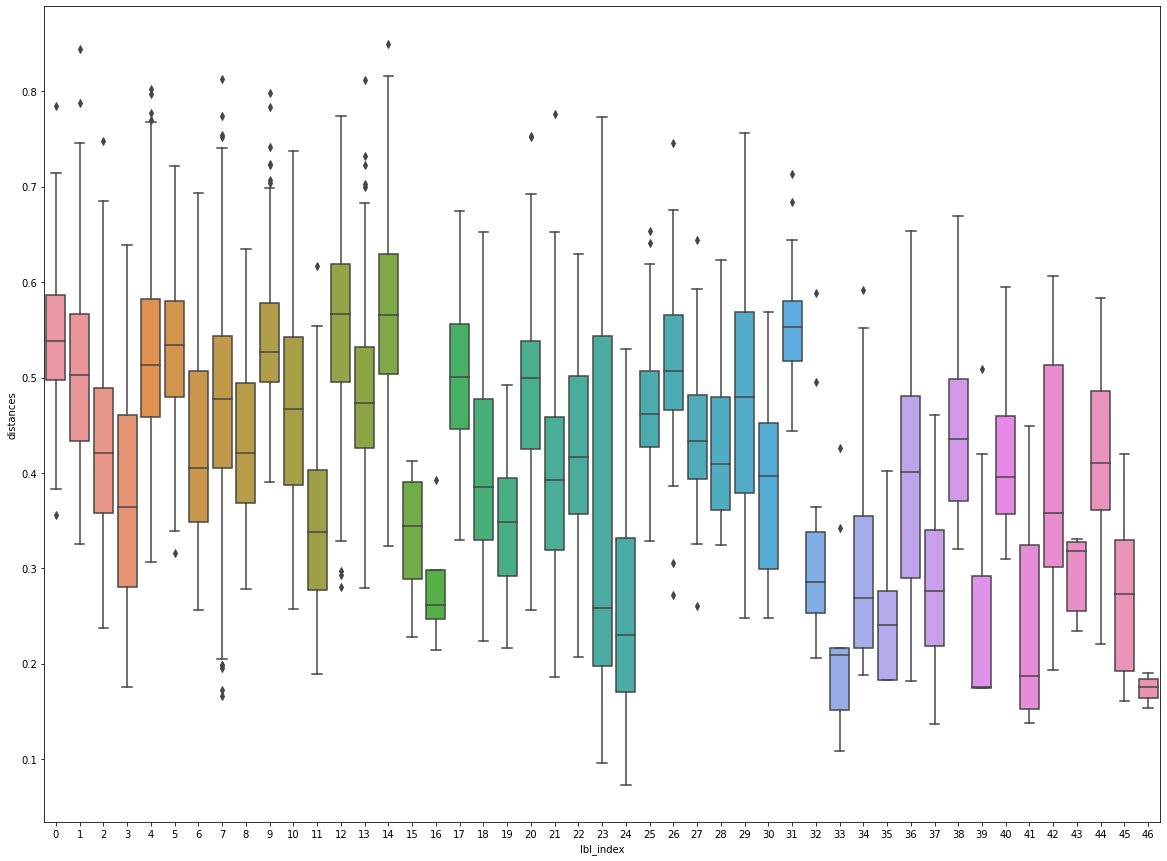

In [114]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(20,15))
sns.boxplot(x="lbl_index", y="distances", data=train_vectors)
plt.show()

In [0]:
grouped = train_vectors.groupby('lbl_index')
min_mean_max_mapping = {} 
for name, values in grouped:
  min_mean_max_mapping[name] = {'min': values.distances.min(), 'mean':values.distances.mean(), 'max': values.distances.max(), 'center_emb': values.vecs.mean()}


In [0]:
vectors_with_centers = pd.concat([train_vectors, center_of_classes])

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(vectors_with_centers['vecs'].tolist())

In [0]:
import matplotlib.pyplot as plt
import numpy as np


def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

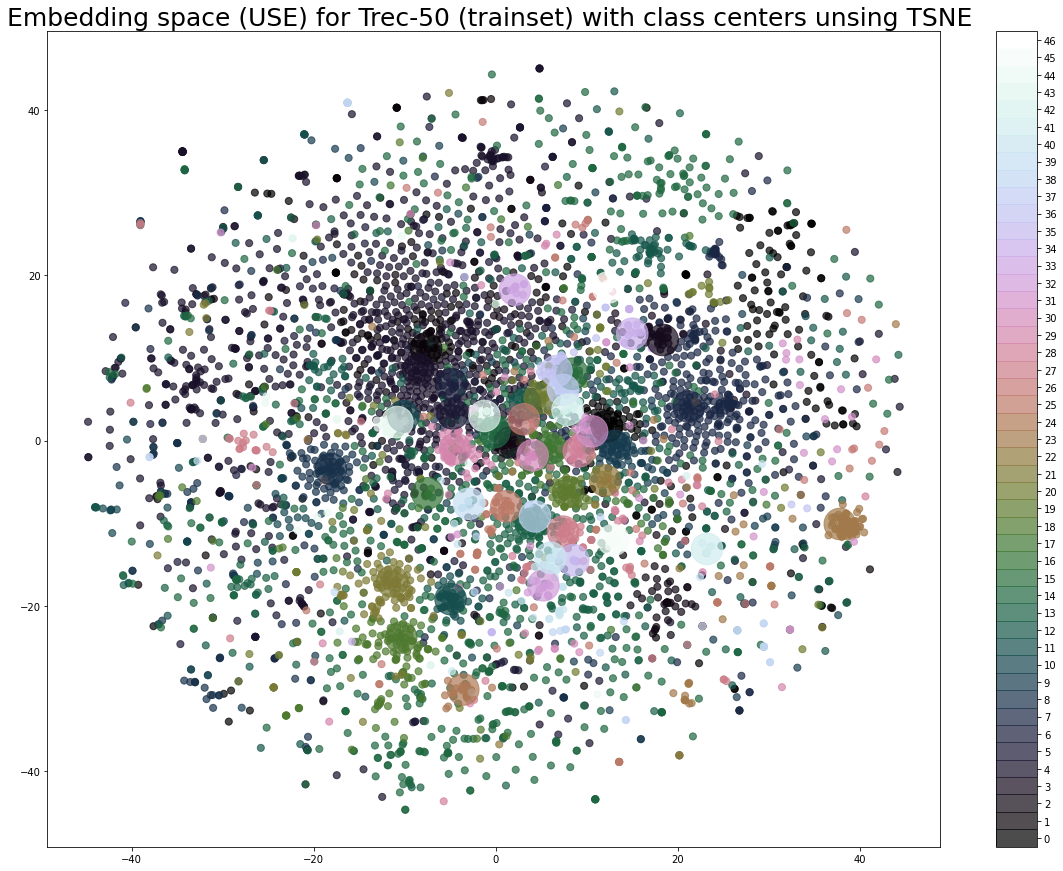

In [122]:
N = len(train.labels.unique())

x = [x for x,y in X_embedded][:-len(train.labels.unique())]
y = [y for x,y in X_embedded][:-len(train.labels.unique())]
c = vectors_with_centers.lbl_index[:-len(train.labels.unique())]

x_center = [x for x,y in X_embedded][-len(train.labels.unique()):]
y_center = [y for x,y in X_embedded][-len(train.labels.unique()):]
c_center = vectors_with_centers.lbl_index[-len(train.labels.unique()):]
                                                         
plt.figure(figsize=(20,15))
# Edit: don't use the default ('jet') because it makes @mwaskom mad...
plt.scatter(x, y, c=c, s=50, alpha=0.7, cmap=discrete_cmap(N, 'cubehelix'))
plt.scatter(x_center, y_center, c=c_center, s=1000, alpha=0.7, cmap=discrete_cmap(N, 'cubehelix'))
plt.colorbar(ticks=range(N))
plt.title('Embedding space (USE) for Trec-50 (trainset) with class centers unsing TSNE ', {'fontsize': 25})
plt.clim(-0.5, N - 0.5)
plt.show()